# 스태킹 앙상블

스태킹(Stacking)은 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 점에서 배깅 및 부스팅과 공통점을 가지고 있다.

가장 큰 차이점은 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 점이다.

즉, 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML 알고지즘으로 최종 학습을 수행하고 테스트 데이터를기반으로 다시 최종 예측을 수행하는 방식이다.

스태킹 모델은 두 종류의 모델이 필요하다. 첫 번째는 개별적인 기반 모델이고, 두 번째는 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어 학습하는 최종 메타 모델이다.

스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것이다.

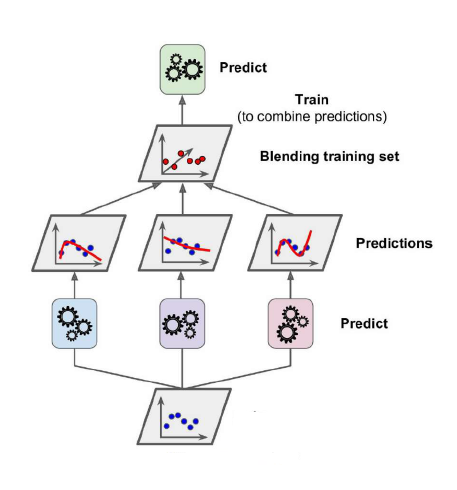

M개의 로우, N개의 피처(칼럼)을 가진 데이터 세트에 스태킹 앙살블을 적용한다고 가정.

학습에 사용할 ML 알고리즘 모델은 모두 3개. 먼저 모델별로 각각 학습을 시킨 뒤 예측을 수행하면 각각 M개의 로우를 가진 1개의 레이블 값을 도출할 것이다.

모델별로 도출된 예측 레이블 값을 다시 합해서(스태킹) 새로운 데이터 세트를 만들고 이렇게 스태킹된 데이터 세트에 최종 모델을 적용해 최종 예측을 하는 것이 스태킹 앙살블 모델이다.

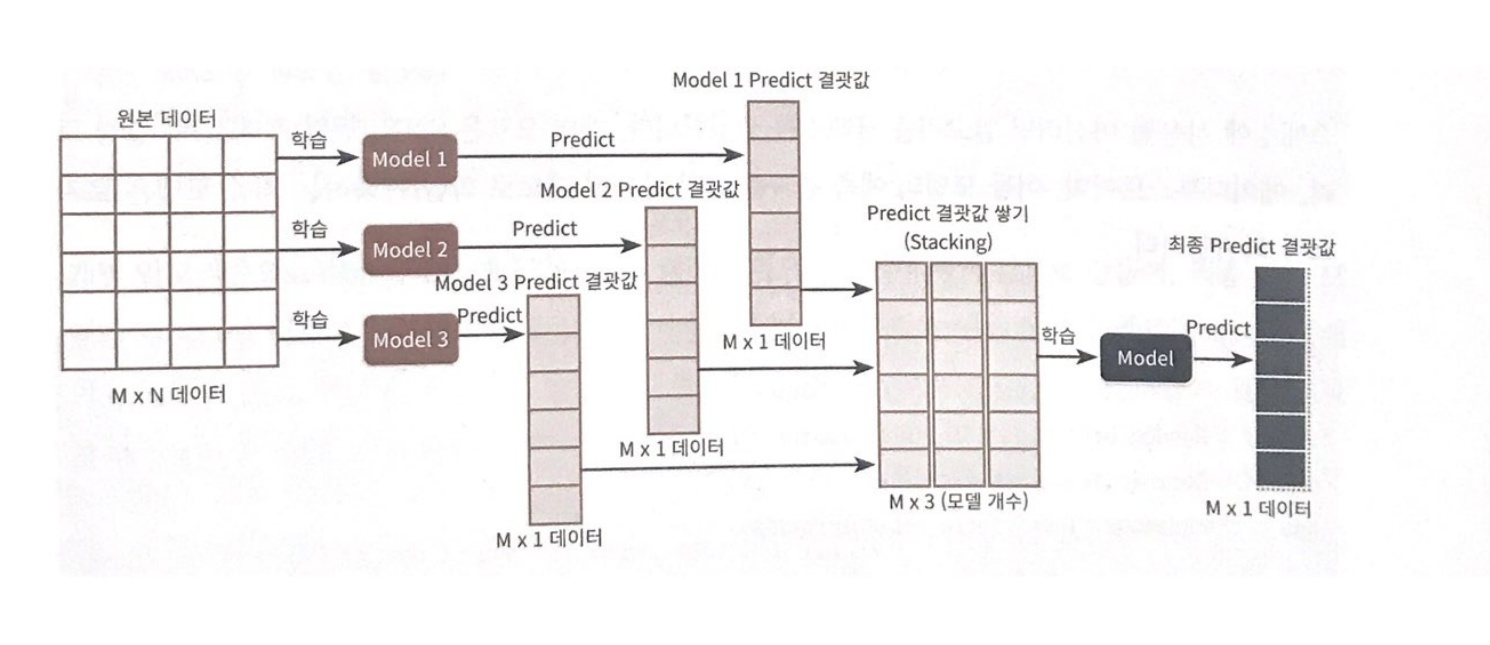![image.png]()

In [1]:
# 기본 스태킹 모델, 위스콘신 암 데이터 세트에 적용
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()
X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

스태킹에 사용될 머신러닝 알고리즘 클래스를 생성한다. 개별 모델은 KNN, 랜덤 포레스트, 결정 트리, AdaBoost이다. 이들 모델의 예측 결과를 합한 데이터 세트로 학습/예측하는 최종 모델은 로지스틱 회귀이다.

In [2]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

# 개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [3]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도 : {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도 : {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('AdaBoost 정확도 : {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도 : 0.9211
랜덤 포레스트 정확도 : 0.9649
결정 트리 정확도 : 0.8947
AdaBoost 정확도 : 0.9561


개별 알고리즘으로부터 예측된 예측값을 칼럼 레벨로 옆으로 붙여서 피처 값으로 만들어, 최종 메타 모델인 로지스틱 회귀에서 학습 데이터로 다시 사용.

반환된 예측 데이터 세트는 1차원 형태의 ndarray이므로 먼저 반환된 예측 결과를 행 형태로 붙인 뒤, 넘파이의 transpose()를 이용해 행과 열을 바꾼 ndarray로 변환.

In [4]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


이렇게 예측 데이터로 생성된 데이터 세트를 기반으로 최종 메타 모델인 로지스틱 회귀를 학습하고 예측 정확도 측정

In [5]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)
print('최종 메타 모델의 예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도 : 0.9737


최종 메타 모델에서 학습하고 예측한 결과, 정확도가 97.37%로 개별 모델 정확도보다 향상되었다.(무조건 이러한 스태킹 기법으로 예측한다고 좋아진다는 보장은 없다)



# CV 세트 기반의 스태킹

CV 세트 기반의 스태킹 모델은 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트를 이용한다.

<br/>

**CV 세트 기반의 스태킹은 이에 대한 개선**
- 개별 모델들이 각각 교차 검증으로 메타 모델을 위한 학습용 스태킹 데이터 생성
- 예측을 위한 테스트용 스태킹 데이터를 생성
- 이를 기반으로 메타 모델이 학습과 예측을 수행

### CV 세트 기반 스태킹의 2단계의 스텝
* 스텝 1 : 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성

* 스텝 2 : 스텝 1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성. 마찬가지로 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합쳐 메타 모델이 예측할 최종 테스트 데이터 세트를 생성. 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 세트를 예측하고, 원본 테스트 데이터의 레이블 데이터를 기반으로 평가.

**핵심 : 개별 모델에서 메타 모델인 2차 모델에서 사용될 학습용 데이터와 테스트용 데이터를 교차 검증을 통해 생성하는 것.**

학습용 데이터를 N개의 폴드(Fold)로 나눈다. 3개의 폴드 세트로 가정.

1. 학습용 데이터를 3개의 폴드로 나누되, 2개의 폴드는 학습을 위한 데이터 폴드로, 나머지 1개는 검증을 위한 데이터 폴드로 둔다.

2. 2개의 폴드로 개별 모델 학습. 학습된 개별 모델들은 검증 폴드 1개 데이터로 예측하고 결과를 저장. 이러한 로직을 3번 반복하며 학습 데이터와 검증 데이터 세트를 변경해가면서 학습 후 예측 결과를 별도로 저장. 이렇게 만들어진 예측 데이터는 메타 모델을 학습시키는 학습 데이터로 사용

3. 2개의 학습 폴드 데이터로 학습된 개별 모델은 원본 테스트 데이터를 예측하여 예측값을 생성. 이렇게 로직을 3번 반복하면서 이 예측값의 평균으로 최종 결과값을 생성하고 이를 메타 모델을 위한 테스트 데이터로 사용.

In [6]:
# 스텝 1
# 개별 모델이 메타 모델을 위한 학습용 데이터와 테스트 데이터를 생성
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [7]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


스텝 2 구현. 위 get_stacking_base_datasets() 호출로 반환된 각 모델별 학습 데이터와 테스트 데이터를 합치면 된다. 넘파이의 concatenate()를 이용해 쉽게 이와 같은 기능을 수행한다. concatenate()는 여러 개의 넘파이 배열을 칼럼 또는 로우 레벨로 합쳐주는 기능을 제공한다.

In [8]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape :', X_train.shape, '원본 테스트 피처 Shape :', X_test.shape)
print('스태킹 학습 피처 데이터 Shape :', Stack_final_X_train.shape, '스태킹 테스트 피처 데이터 Shape :', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape : (455, 30) 원본 테스트 피처 Shape : (114, 30)
스태킹 학습 피처 데이터 Shape : (455, 4) 스태킹 테스트 피처 데이터 Shape : (114, 4)


스태킹 학습 피처 데이터는 원본 학습 피처 데이터와 로우(Row) 크기는 같고, 4의 개별 모델 예측값을 합친 것이르모 칼럼 크기는 4이다.

최종 메타 모델인 로지스틱 회귀를 스태킹된 학습용 피처 데이터 세트와 원본 학습 레이블 데이터로 학습한 후에 스태킹된 테스트 데이터 세트로 예측하고, 예측 결과를 원본 테스트 레이블 데이터와 비교하여 정확도를 측정하자.

In [9]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도 : 0.9737


스태킹은 여러 개의 개별 모델들이 생성한 예측 데이터를 기반으로 최종 메타 모델이 학습할 별도의 학습 데이터 세트와 예측할 테스트 데이터 세트를 재생성하는 기법이다. 스태킹 모델의 핵심은 바로 메타 모델이 사용할 학습 데이터 세트와 예측 데이터 세트를 개별 모델의 예측 값들을 스태킹 형태로 결합해 생성하는 데 있다.

스태킹을 현실 모델에 적용하는 경우는 그렇게 많지 않다. 다만 캐글과 같은 대회에서 높은 순위를 차지하기 위해 조금이라도 성능 수치를 높여야 할 경우 자주 사용된다.